# Approximate Mass-Sheet Transforms

## Composite + approx MST
This notebooks profies an assessment of how we can constrain lens model families with imaging data and kinematics.




This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from pylab import rc

rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

np.random.seed(42)

# import lenstronomy modules
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
from  lenstronomy.Util import param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

## simulation choices

In [2]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

lensCosmo = LensCosmo(z_lens=0.6, z_source=1.5, cosmo=cosmo)

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91
#kernel_cut = kernel_util.cut_psf(kernel, kernel_size)

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
psf_class = PSF(**kwargs_psf)

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


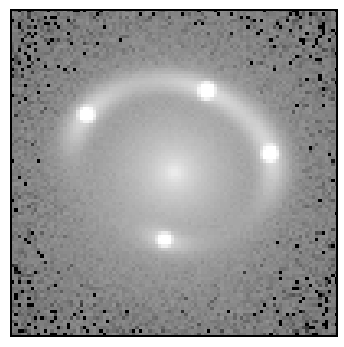

In [3]:
# lensing quantities
kwargs_nfw = {'alpha_Rs': 1.5, 'Rs': 8, 'center_x': 0.0, 'center_y': 0.0, 'e1': -0.1, 'e2': 0.01}  # parameters of the deflector lens model
r_eff = 1.0
kwargs_hernquist = {'sigma0': 2.0, 'Rs': r_eff*0.551, 'center_x': 0.0, 'center_y': 0.0}

kwargs_shear = {'gamma1': 0.01, 'gamma2': -0.05}  # shear values to the source plane
kwargs_core = {'sigma0': 0.0, 'r_core': 8, 'center_x': 0, 'center_y': 0}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['NFW_ELLIPSE', 'SHEAR', 'HERNQUIST', 'CORED_DENSITY_2']
kwargs_lens = [kwargs_nfw, kwargs_shear, kwargs_hernquist, kwargs_core]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.
source_y = 0.15


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 2000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
# for this exercise we do not include lens light in the imaging model and fix it for the kinematics to be a Hernquist profile with a half light radius parameter


lens_light_model_list = ['HERNQUIST']
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
kwargs_hernquist_light = {'amp': 4000, 'Rs': r_eff*0.551, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_hernquist_light]


lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.savefig('/Users/sibirrer/Science/Publications/MST_H0/mock_lens_composite.pdf')
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 10]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [-1.34129483  1.46163589  0.49190947 -0.14825855] [ 0.88357155  0.28943611  1.25022332 -1.02696254] are:  [-81.70437309 -71.88163379 -66.3031417  -33.95537095]
the measured relative delays are:  [10.86759805 16.81784935 38.38380369]


## kinematics
Kinematics can provide important complementary information about the lens to constrain cosmography

In [5]:
# observational conditions of the spectroscopic campagne
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7

kwargs_aperture = {'aperture_type': 'slit', 'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OM'
aperture_type = 'slit'

kwargs_galkin_numerics = {'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals

r_ani = 1.
r_eff = 0.2
kwargs_anisotropy = {'r_ani': r_ani}
kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

from lenstronomy.Analysis.kinematics_api import KinematicsAPI
kin_api = KinematicsAPI(z_lens, z_source, kwargs_model, kwargs_aperture, 
                        kwargs_seeing, anisotropy_model, cosmo=cosmo, Hernquist_approx=True, kwargs_numerics_galkin=kwargs_galkin_numerics,
                        lens_model_kinematics_bool=[True, False, True, True], light_model_kinematics_bool=[True],
                        sampling_number=10000 # numerical ray-shooting, should converge -> infinity
                       )

vel_disp = kin_api.velocity_dispersion(kwargs_lens, kwargs_lens_light, kwargs_anisotropy, r_eff=r_eff, theta_E=None,
                            gamma=None, kappa_ext=0)

print(vel_disp, 'velocity dispersion in km/s')

182.57840907958806 velocity dispersion in km/s


## Model and parameter choices

In [6]:
lens_model_list_fit = ['NFW_ELLIPSE', 'SHEAR', 'HERNQUIST', 'CORED_DENSITY_2_MST']

kwargs_model_fit = {'lens_model_list': lens_model_list_fit, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(copy.deepcopy(kwargs_nfw))
kwargs_lens_sigma.append({'alpha_Rs': 0.5, 'Rs': 2, 'center_x': 0.01, 'center_y': 0.01, 'e1': 0.2, 'e2': 0.2})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 2, 'center_x': -10, 'center_y': -10, 'e1': -0.5, 'e2': -0.5})
kwargs_upper_lens.append({'alpha_Rs': 10., 'Rs': 20, 'center_x': 10, 'center_y': 10, 'e1': 0.5, 'e2': 0.5})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
#kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
kwargs_lens_init.append(copy.deepcopy(kwargs_shear))
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})
kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})

fixed_lens.append({}) 
kwargs_lens_init.append(copy.deepcopy(kwargs_hernquist))
kwargs_lens_sigma.append({'sigma0': 0.2, 'Rs': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'sigma0': 0., 'Rs': 0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'sigma0': 20, 'Rs': 10, 'center_x': 10, 'center_y': 10})

#fixed_lens.append({'r_core': kwargs_core['r_core']})
fixed_lens.append({})
kwargs_lens_init.append({'lambda_approx': 1 - kwargs_core['sigma0'], 'r_core': kwargs_core['r_core'], 'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'lambda_approx': 0.1, 'r_core': 5, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'lambda_approx': 0, 'r_core': 0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'lambda_approx': 2, 'r_core': 20, 'center_x': 10, 'center_y': 10})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append(kwargs_hernquist_light)
kwargs_lens_light_init.append(kwargs_hernquist_light)
kwargs_lens_light_sigma.append({'Rs': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'Rs': 0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'Rs': 20, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


In [7]:

# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'joint_lens_with_lens': [[0, 3, ['center_x', 'center_y']]],
                      'joint_lens_with_light': [[0, 2, ['center_x', 'center_y', 'Rs']]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model_fit, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 100}],
        ['MCMC', {'n_burn': 600, 'n_run': 1000, 'walkerRatio': 10, 'sigma_scale': .2}]
]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.001773129012167 reduced X^2 of best position
-4997.846140641701 logL
9978 effective number of data points
[{'Rs': 7.338224960843552, 'alpha_Rs': 1.4281779064248388, 'e1': -0.09792374747186447, 'e2': 0.009688342971615917, 'center_x': -3.871149136383872e-05, 'center_y': -0.00012028253209927229}, {'gamma1': 0.013572950176485936, 'gamma2': -0.05088027390903736, 'ra_0': 0, 'dec_0': 0}, {'sigma0': 2.00468772578966, 'Rs': 0.551, 'center_x': 0, 'center_y': 0}, {'lambda_approx': 1.0931809878367706, 'r_core': 8.326373424408324, 'center_x': 0.0, 'center_y': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.10128078468751069, 'n_sersic': 1.0065672118061886, 'e1': 0.05975912259335066, 'e2': 0.09315615521754247, 'center_x': 2.9949042103266654e-05, 'center_y': 0.15129333574374473}] source result
[{'amp': 4000, 'Rs': 0.551, 'center_x': 0, 'center_y': 0}] lens light result
[{'ra_image': array([-1.34142512,  1.46168316,  0.49192053, -0.1482919

  0%|          | 0/1600 [00:00<?, ?it/s]/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1600/1600 [2:04:35<00:00,  5.47s/it] 

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  600
Sampling iterations (in current run): 1600
7480.332957983017 time taken for MCMC sampling
8037.367352962494 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


## analyse model output

-0.9992987062171059 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9992987062171059


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:547: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:517: RuntimeWarning: invalid 

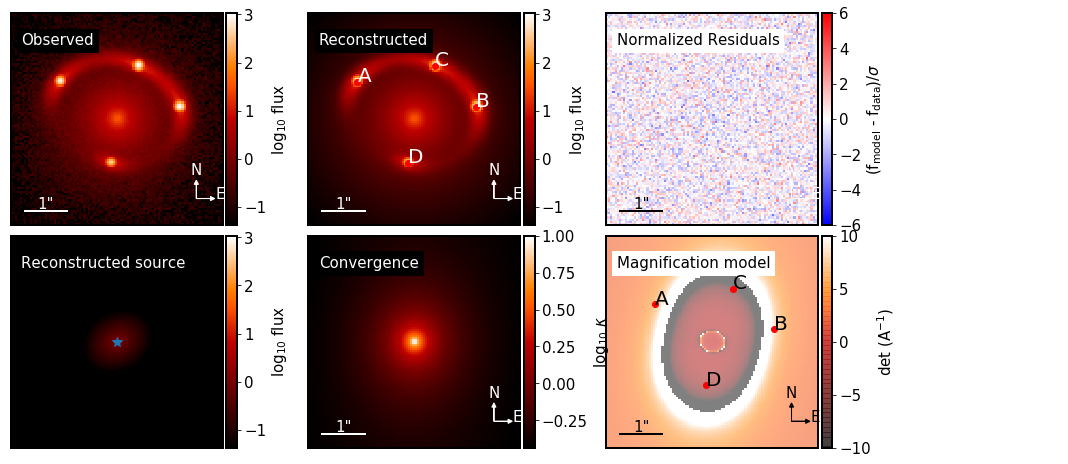

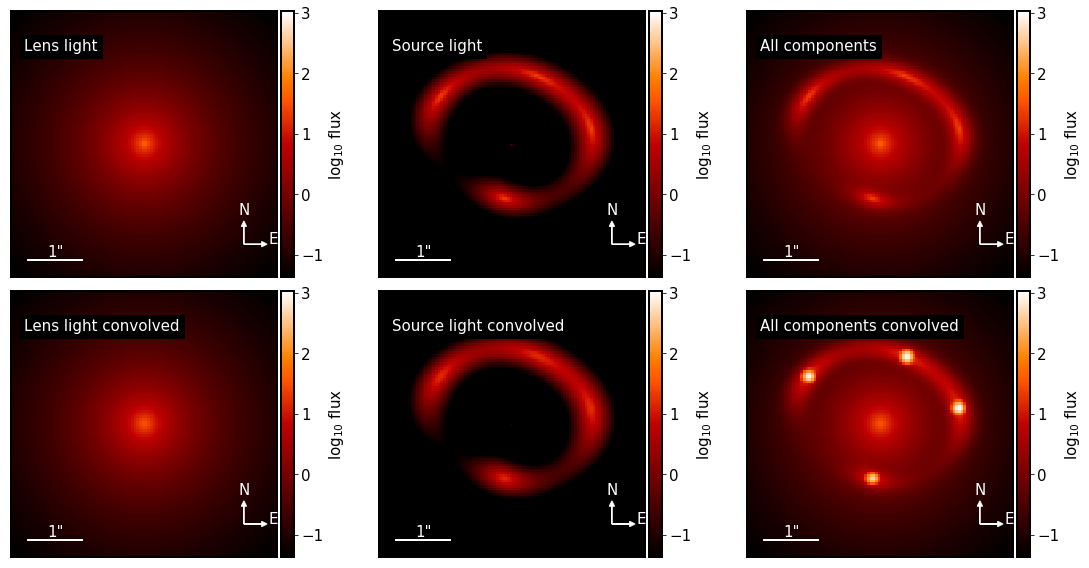

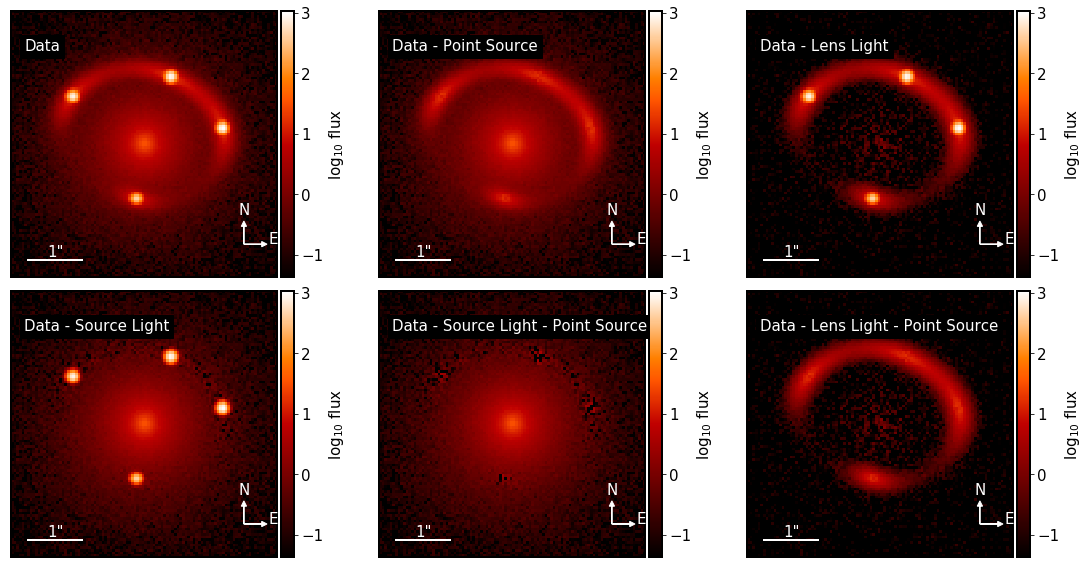

In [8]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model_fit, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()


number of non-linear parameters in the MCMC process:  19
parameters in order:  ['Rs_lens0', 'gamma1_lens1', 'gamma2_lens1', 'sigma0_lens2', 'lambda_approx_lens3', 'r_core_lens3', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  190000


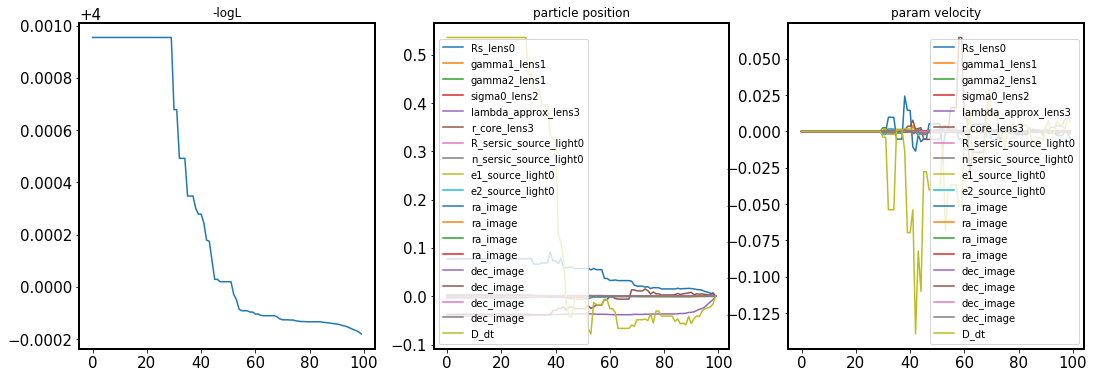

<Figure size 432x288 with 0 Axes>

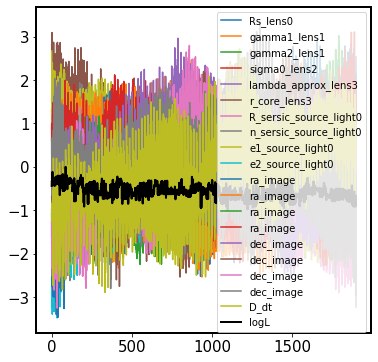

In [9]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model_fit, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$R_s$", r"$\alpha_{Rs}$", r"$\Sigma_{\rm star}$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r"$D_{\Delta t}$", r"$\lambda_{\rm approx}$", r"$R_{\rm c}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    #fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    #delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    phi_ext, gamma_ext = param_util.shear_cartesian2polar(gamma1, gamma2)
    lambda_approx = kwargs_result['kwargs_lens'][3]['lambda_approx']
    r_core = kwargs_result['kwargs_lens'][3]['r_core']
    alpha_Rs = kwargs_result['kwargs_lens'][0]['alpha_Rs']
    Rs = kwargs_result['kwargs_lens'][0]['Rs']
    sigma0 = kwargs_result['kwargs_lens'][2]['sigma0']

    mcmc_new_list.append([Rs, alpha_Rs, sigma0, phi_ext, gamma_ext, D_dt, lambda_approx, r_core])



3329.6653609254795


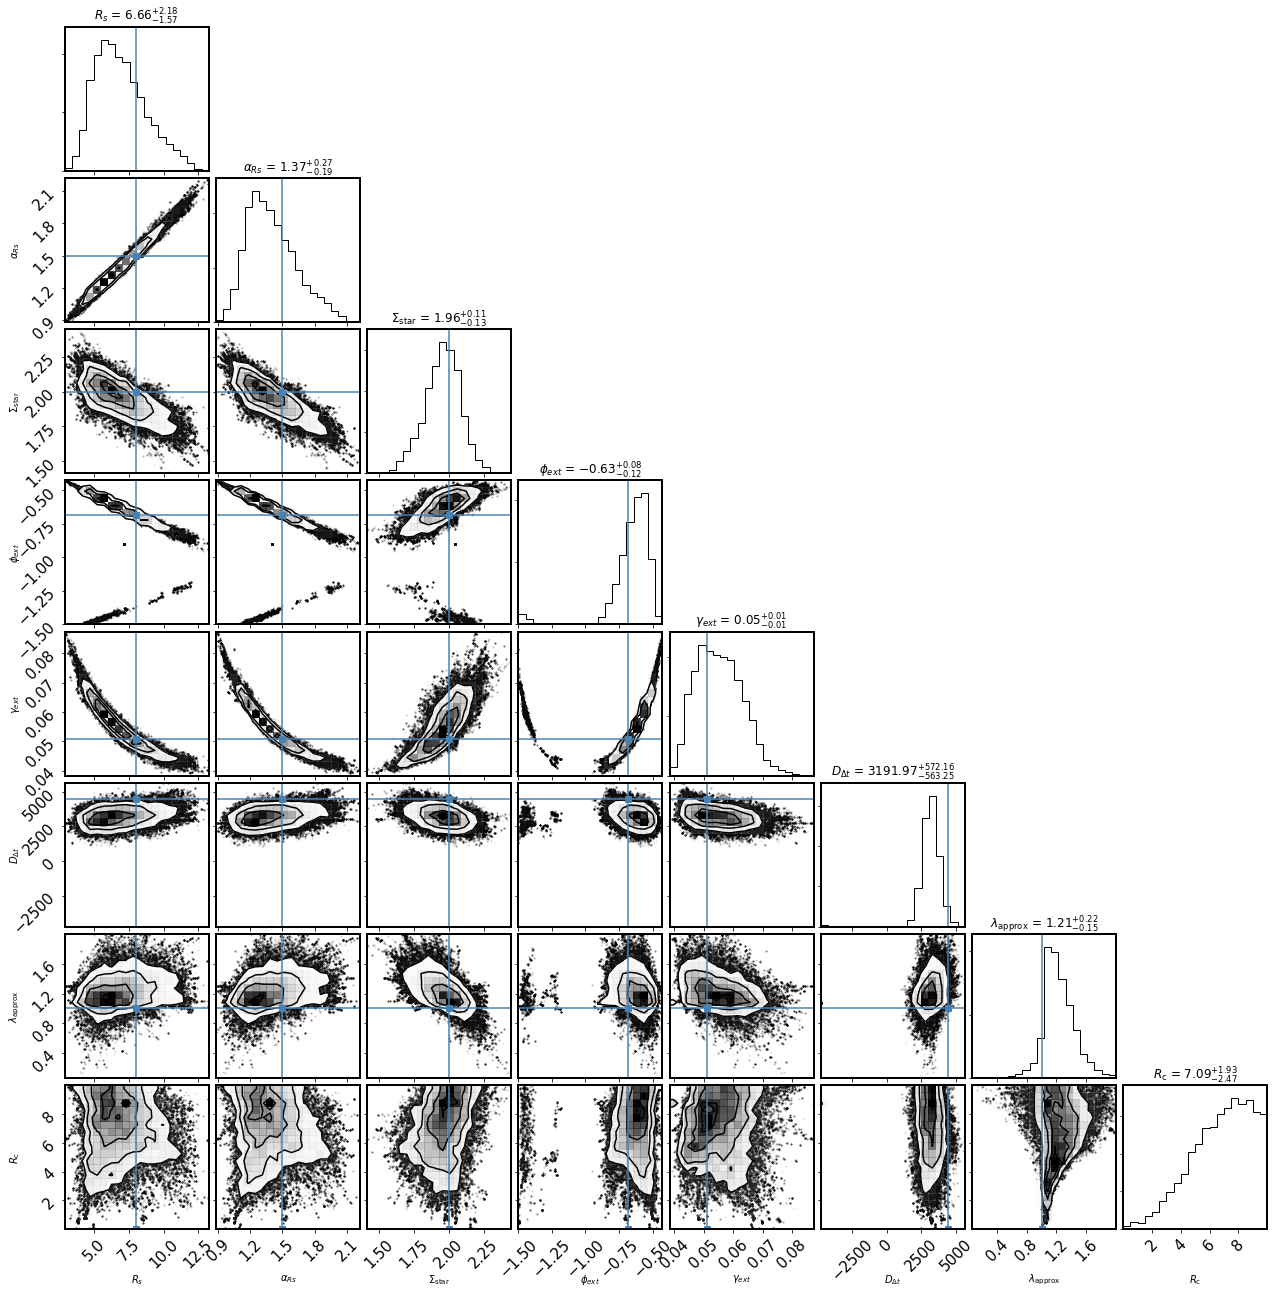

In [10]:
phi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_shear['gamma1'], kwargs_shear['gamma2'])
truths = [kwargs_nfw['Rs'], kwargs_nfw['alpha_Rs'], kwargs_hernquist['sigma0'], phi_ext, gamma_ext, lensCosmo.ddt, 1, 0]

plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True, truths=truths)
#plt.savefig('/Users/sibirrer/Science/Publications/MST_H0/lambda_int_posteriors_composite.pdf')
# here we just re-compute the true Ddt that needs to be recovered
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)

## Trend in core radius and allowed density
Here we further investigate the core size and lambda parameter constraints that can be provided by the imaging mock example. We aim to translate a prior in core size and density space into an allowed MST

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


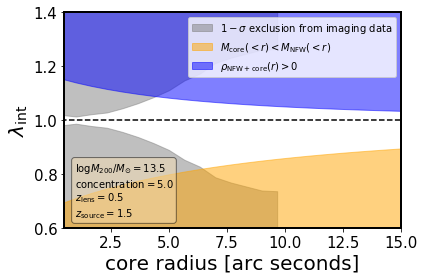

In [11]:
mcmc_new_list = np.array(mcmc_new_list)
r_core_posterior = mcmc_new_list[:, 7]
lambda_posterior = mcmc_new_list[:, 6]

r_list = np.linspace(0, 20, 31)
lambda_sigma_list = []
for i in range(len(r_list) - 1):
    lambda_select = lambda_posterior[(r_core_posterior > r_list[i]) & (r_core_posterior < r_list[i+1])]
    lambda_sigma = np.std(lambda_select)
    lambda_sigma_list.append(lambda_sigma)
lambda_sigma_list = np.array(lambda_sigma_list)
r_array = (r_list[1:] + r_list[0:-1]) / 2
#mass_3d_core = lambda_mst * r_core**2 * np.pi
#plt.plot(r_array, lambda_sigma_list)
plt.fill_between(r_array, lambda_sigma_list+1, 2, alpha=0.5, color='grey', 
                 label=r'$1-\sigma$ exclusion from imaging data')
plt.fill_between(r_array, -lambda_sigma_list+1, 0, alpha=0.5, color='grey')

# and now we look at a typical NFW profile in projection in the convergence profile

M200 = 10**13.5
c = 5
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.Profiles.nfw import NFW
nfw = NFW()
lensCosmo = LensCosmo(z_lens=0.6, z_source=1.5, cosmo=cosmo)
Rs_angle, alpha_Rs =lensCosmo.nfw_physical2angle(M200, c)
kwargs_nfw_plot = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle}
nfw_lens = LensModel(lens_model_list=['NFW'])

kappa_r_nfw = nfw_lens.kappa(r_array, 0, [kwargs_nfw_plot])

mass_3d_nfw = nfw.mass_3d_lens(r_array, **kwargs_nfw_plot)
lambda_max_nfw = 1 - mass_3d_nfw / r_array**2 / np.pi
plt.fill_between(r_array, lambda_max_nfw, 0, alpha=0.5, color='orange', label=r'$M_{\rm core}(<r) < M_{\rm NFW}(<r)$')

density_nfw = nfw.density_lens(r_array, **kwargs_nfw_plot)
kappa_max = density_nfw * r_array
plt.fill_between(r_array, 1 + kappa_max, 2, alpha=0.5, color='blue', label=r'$\rho_{\rm NFW + core}(r) > 0$')

plt.legend()
plt.xlabel('core radius [arc seconds]', fontsize=20)
plt.ylabel(r'$\lambda_{\rm int}$', fontsize=20)
plt.ylim([0.6, 1.4])
plt.xlim([0.5, 15])


textstr = '\n'.join((
    r'$\log M_{200} /M_{\odot}=%.1f$' % (np.log10(M200), ),
    r'${\rm concentration}=%.1f$' % (c, ),
    r'$z_{\rm lens}=%.1f$' % (z_lens, ),
    r'$z_{\rm source}=%.1f$' % (z_source)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
plt.text(0.05, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.plot(r_array, np.ones_like(r_array), 'k--')
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Publications/MST_H0/lambda_int_bounds.pdf')
plt.show()



## Composite + density core profiles in 2d and 3d 
Here we illustrate different choices of $\lambda_{\rm approx}$ with a density core and how they alter the projected 2d density and the radial 3d density of the matter distribution.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


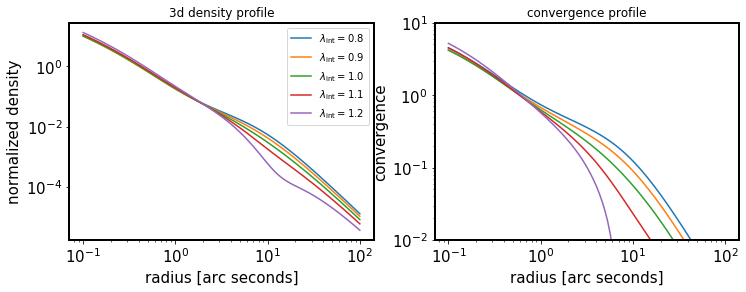

In [12]:
from lenstronomy.LensModel.single_plane import SinglePlane
sp = SinglePlane(lens_model_list=lens_model_list)


f, axes = plt.subplots(1, 2, figsize=(12, 4))
r = np.logspace(start=-1, stop=2, num=100)
kwargs_lens_plot = copy.deepcopy(kwargs_lens)
kwargs_lens_plot[3]['r_core'] = 8
lambda_list = np.linspace(0.8, 1.2, 5)

for lambda_i in lambda_list:
    
    kwargs_lens_plot[0]['alpha_Rs'] = kwargs_lens[0]['alpha_Rs'] * lambda_i
    sigma0 = 1 - lambda_i
    kwargs_lens_plot[2]['sigma0'] = kwargs_lens_plot[2]['sigma0'] * lambda_i
    kwargs_lens_plot[3]['sigma0'] = sigma0
    rho_r = sp.density(r, kwargs_lens_plot, bool_list=[True, False, True, True])
    axes[0].loglog(r, rho_r, label=r'$\lambda_{\rm int} = $' + str(lambda_i))

    f_xx, f_xy, f_yx, f_yy = sp.hessian(r, 0, kwargs_lens_plot, k=[True, False, True, True])
    kappa_r = 1./2 * (f_xx + f_yy)
    axes[1].loglog(r, kappa_r, label=lambda_i)
    
axes[0].set_title('3d density profile')
axes[0].legend()
axes[1].set_ylim(0.01, 10)
axes[0].set_xlabel('radius [arc seconds]', fontsize=15)
axes[0].set_ylabel('normalized density', fontsize=15)
axes[1].set_xlabel('radius [arc seconds]', fontsize=15)
axes[1].set_title('convergence profile')
axes[1].set_ylabel('convergence', fontsize=15)
#plt.legend()
#plt.savefig('/Users/sibirrer/Science/Publications/MST_H0/composite_mst_profile.pdf')
f.show()



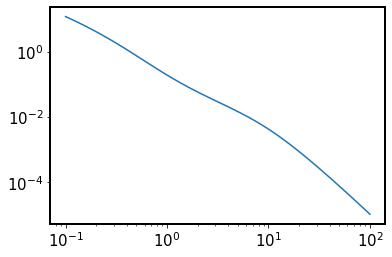

In [13]:
def plot_lambda(lambda_i):
    f, ax = plt.subplots(1, 1, figsize=(6, 4))
    kwargs_lens_plot[0]['alpha_Rs'] = kwargs_lens[0]['alpha_Rs'] * lambda_i
    sigma0 = 1 - lambda_i
    kwargs_lens_plot[2]['sigma0'] = kwargs_lens_plot[2]['sigma0'] * lambda_i
    kwargs_lens_plot[3]['sigma0'] = sigma0
    rho_r = sp.density(r, kwargs_lens_plot, bool_list=[True, False, True, True])
    ax.loglog(r, rho_r, label=r'$\lambda_{\rm int} = $' + str(lambda_i))
    plt.show()
    
plot_lambda(lambda_i=.9)

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


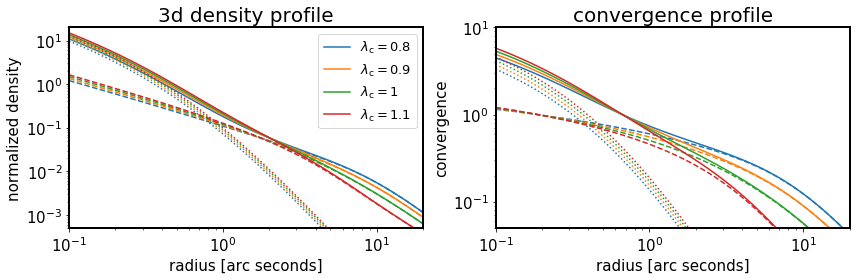

In [18]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_split_components(kwargs_lens, lambda_list, color_list):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    for i, lambda_mst in enumerate(lambda_list):
        color = color_list[i]
        kwargs_lens_plot = copy.deepcopy(kwargs_lens)
        kwargs_lens_plot[0]['alpha_Rs'] = kwargs_lens[0]['alpha_Rs'] * lambda_mst
        sigma0 = 1 - lambda_mst
        kwargs_lens_plot[2]['sigma0'] = kwargs_lens_plot[2]['sigma0'] * lambda_mst
        kwargs_lens_plot[3]['sigma0'] = sigma0
        
        rho_tot = sp.density(r, kwargs_lens_plot, bool_list=[True, False, True, True])
        rho_dm = sp.density(r, kwargs_lens_plot, bool_list=[True, False, False, True])
        rho_bar = sp.density(r, kwargs_lens_plot, bool_list=[False, False, True, False])
        ax = axes[0]
        ax.loglog(r, rho_tot, label=r"$\lambda_{\rm c}=$"+str(lambda_mst), color=color)
        ax.loglog(r, rho_dm, '--', label=None, color=color)
        ax.loglog(r, rho_bar, ':', label=None, color=color)

        ax.set_ylim(0.001, 10)

        ax = axes[1]
        f_xx, f_xy, f_yx, f_yy = sp.hessian(r, 0, kwargs_lens_plot, k=[True, False, True, True])
        kappa_tot = 1./2 * (f_xx + f_yy)
        f_xx, f_xy, f_yx, f_yy = sp.hessian(r, 0, kwargs_lens_plot, k=[True, False, False, True])
        kappa_dm = 1./2 * (f_xx + f_yy)
        f_xx, f_xy, f_yx, f_yy = sp.hessian(r, 0, kwargs_lens_plot, k=[False, False, True, False])
        kappa_bar = 1./2 * (f_xx + f_yy)
        ax.loglog(r, kappa_tot, label=r"$\lambda_{\rm int}=$"+str(lambda_mst), color=color)
        ax.loglog(r, kappa_dm, '--', label=None, color=color)
        ax.loglog(r, kappa_bar, ':', label=None, color=color)
        
        ax.set_ylim(0.01, 10)
        
    axes[0].set_title('3d density profile', fontsize=20)
    axes[0].legend(fontsize=13)
    #axes[0].set_ylim(0.005, 20)
    #axes[1].set_ylim(0.05, 10)
    #axes[0].set_xlim(0.1, 5)
    #axes[1].set_xlim(0.1, 5)
    
    axes[0].set_ylim(0.0005, 20)
    axes[1].set_ylim(0.05, 10)
    axes[0].set_xlim(0.1, 20)
    axes[1].set_xlim(0.1, 20)
    axes[0].set_xlabel('radius [arc seconds]', fontsize=15)
    axes[0].set_ylabel('normalized density', fontsize=15)
    axes[1].set_xlabel('radius [arc seconds]', fontsize=15)
    axes[1].set_title('convergence profile', fontsize=20)
    axes[1].set_ylabel('convergence', fontsize=15)
        
    #axes[0].set_title('3d density profile')
    #axes[1].set_title('convergence profile')
    #axes[0].legend()
    #axes[1].legend()
    return f, axes
    


f, axes = plot_split_components(kwargs_lens, lambda_list=[0.8, 0.9, 1, 1.1], color_list=color_list)
f.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/composite_split_mst.pdf')
f.show()



## velocity dispersion dependence
Here we compute the scaling of the velocity dispersion with $\lambda_{\rm approx}$

In [15]:

kwargs_lens_kin = copy.deepcopy(kwargs_lens)
kwargs_lens_kin[3]['sigma0'] = 0

def velocity_dependence(kwargs_lens, lambda_approx_list, r_core):

    kwargs_lens_result = copy.deepcopy(kwargs_lens)

    vel_disp_list = []

    kwargs_lens_kin = copy.deepcopy(kwargs_lens)
    kwargs_lens_kin[3]['sigma0'] = 0
    kwargs_lens_kin[3]['r_core'] = r_core
    vel_disp_0 = kin_api.velocity_dispersion(kwargs_lens_kin, kwargs_lens_light, kwargs_anisotropy, r_eff=r_eff, theta_E=None,
                            gamma=None, kappa_ext=0)

    #vel_disp_0 = kin_api.velocity_dispersion_numerical(kwargs_lens_kin, kwargs_lens_light, kwargs_anisotropy, kwargs_aperture,
    #                                          kwargs_seeing, anisotropy_model, r_eff=r_eff, theta_E=None, Hernquist_approx=True,
    #                                          kwargs_numerics=kwargs_galkin_numerics, kappa_ext=0)


    for lambda_approx in lambda_approx_list:
        sigma0 = 1 - lambda_approx
        kappa_ext = 0
        kwargs_lens_kin = copy.deepcopy(kwargs_lens)
        #del kwargs_lens_kin[2]['lambda_approx']
        kwargs_lens_kin[3]['sigma0'] = sigma0
        kwargs_lens_kin[3]['r_core'] = r_core

        kwargs_lens_kin[0]['alpha_Rs'] = kwargs_lens[0]['alpha_Rs'] * lambda_approx
        kwargs_lens_kin[2]['sigma0'] = kwargs_lens[2]['sigma0'] * lambda_approx
        vel_disp = kin_api.velocity_dispersion(kwargs_lens_kin, kwargs_lens_light, kwargs_anisotropy, r_eff=r_eff, theta_E=None,
                            gamma=None, kappa_ext=0)
        #vel_disp = kin_api.velocity_dispersion_numerical(kwargs_lens_kin, kwargs_lens_light, kwargs_anisotropy, kwargs_aperture,
        #                                      kwargs_seeing, anisotropy_model, r_eff=r_eff, theta_E=None, Hernquist_approx=True,
        #                                      kwargs_numerics=kwargs_galkin_numerics, kappa_ext=kappa_ext)
        vel_disp_list.append(vel_disp)
    return np.array(vel_disp_list), vel_disp_0



In [16]:
lambda_approx_list = np.linspace(0.6, 1.4, 20)
r_core_list = [0.1, 5, 10]
vel_disp_list_r = []
vel_disp_0_r = []
for r_core in r_core_list:
    vel_disp_list, vel_disp_0 = velocity_dependence(kwargs_lens, lambda_approx_list, r_core)
    vel_disp_list_r.append(vel_disp_list)
    vel_disp_0_r.append(vel_disp_0)
    print(r_core)

0.1
5
10


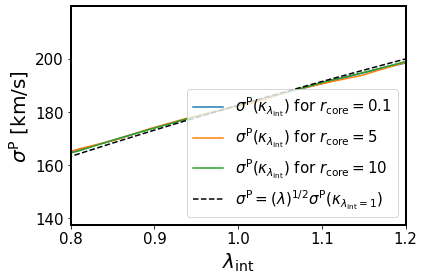

In [17]:
for i in range(len(r_core_list)):
    vel_disp_list = vel_disp_list_r[i]
    vel_disp_0 = vel_disp_0_r[i]

    plt.plot(lambda_approx_list, vel_disp_list, label=r'$\sigma^{\rm P}(\kappa_{\lambda_{\rm int}})$ for $r_{\rm core} =$'+str(r_core_list[i]))
plt.ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=20)
plt.xlabel(r'$\lambda_{\rm int}$', fontsize=20)
plt.plot(lambda_approx_list, vel_disp_0*np.sqrt(lambda_approx_list), 'k--', label=r"$\sigma^{\rm P} = (\lambda)^{1/2} \sigma^{\rm P}(\kappa_{\lambda_{\rm int} = 1})$")
plt.legend(fontsize=15)
plt.xlim([0.8, 1.2])
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Publications/MST_H0/kinematics_mst_composite.pdf')
plt.show()